In [ ]:
!pip install muSpectre

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 8.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import muSpectre
from muFFT import Stencils2D

In [ ]:
# Function to generate noisy and clean images
def create_noisy_image():
    image = np.zeros((29, 29), dtype=np.uint8)
    # Define the coordinates of the center of the hole
    center_x, center_y = 15, 15
    # Sample length and breadth from the specified sets
    length = np.random.choice([13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
    breadth = np.random.choice([5, 6, 7, 8, 9, 10, 11])
    # Calculate the coordinates of the hole's bounding box
    x1, y1 = center_x - length // 2, center_y - breadth // 2
    x2, y2 = x1 + length, y1 + breadth
    # Set the pixels within the hole's bounding box to 0 (black pixels)
    image[y1:y2, x1:x2] = 1
    # Create a random binary noise mask of the same size as the hole
    noise_mask = np.random.randint(0, 2, size=(breadth, length), dtype=np.uint8)
    # Overlay the noise mask on the original image using XOR
    image[y1:y2, x1:x2] = image[y1:y2, x1:x2] ^ noise_mask
    # Define the size of the clean area (4 pixels smaller than the hole dimensions)
    clean_length = length - 3
    clean_breadth = breadth - 3
    # Calculate the coordinates of the area to be cleaned
    clean_x1, clean_y1 = center_x - clean_length // 2, center_y - clean_breadth // 2
    clean_x2, clean_y2 = clean_x1 + clean_length, clean_y1 + clean_breadth
    # Set the pixels within the clean area to 1 (white pixels)
    image[clean_y1:clean_y2, clean_x1:clean_x2] = 1
    noisy_image = np.copy(image)
    return image, x1, x2, y1, y2, noisy_image

# Function to remove artifacts from images
def artefact_eraser(image, x1, x2, y1, y2):
    for x in range(x1 - 3, x2 + 3):
        for y in range(y1 - 3, y2 + 3):
            if image[x, y] == 0:
                if image[x - 1, y] != image[x, y] and image[x + 1, y] != image[x, y]:
                    image[x, y] = 1
                if image[x, y - 1] != image[x, y] and image[x, y + 1] != image[x, y]:
                    image[x, y] = 1
    for x in range(x1 - 3, x2 + 3):
        for y in range(y1 - 3, y2 + 3):
            if image[x, y] == 1:
                if image[x - 1, y] != image[x, y] and image[x + 1, y] != image[x, y]:
                    image[x, y] = 0
                if image[x, y - 1] != image[x, y] and image[x, y + 1] != image[x, y]:
                    image[x, y] = 0
    for x in range(x1 - 3, x2 + 3):
        for y in range(y1 - 3, y2 + 3):
            if image[x, y] == 0:
                if image[x - 1, y] != image[x, y] and image[x + 1, y] != image[x, y]:
                    image[x, y] = 1
                if image[x, y - 1] != image[x, y] and image[x, y + 1] != image[x, y]:
                    image[x, y] = 1
    for x in range(x1 - 3, x2 + 3):
        for y in range(y1 - 3, y2 + 3):
            if image[x, y] == 1:
                if image[x - 1, y] != image[x, y] and image[x + 1, y] != image[x, y]:
                    image[x, y] = 0
                if image[x, y - 1] != image[x, y] and image[x, y + 1] != image[x, y]:
                    image[x, y] = 0
    return image

def index_to_voigt(C):
    n = np.zeros((4,4))
    n = C
    C_voigt =  np.zeros((3,3))
    C_voigt[0,0] = n[0, 0]
    C_voigt[0,1] = n[0, 3]
    C_voigt[1,0] = n[3, 0]
    C_voigt[1,1] = n[3, 3]
    C_voigt[2,2] = n[2, 2]
    return C_voigt


# Function to compute alpha for a given image
def compute_alpha(image):
    nb_grid_pts = image.shape
    domain_lens = [1, 1]
    gradient = Stencils2D.linear_finite_elements
    weights = [1, 1]
    cell = muSpectre.cell.CellData.make(nb_grid_pts, domain_lens)
    cell.nb_quad_pts = 2
    Mat = muSpectre.material.MaterialLinearElastic1_2d
    young_soft = 0
    young_hard = 1
    poisson = .33
    soft = Mat.make(cell, "soft", young_soft, poisson)
    hard = Mat.make(cell, "hard", young_hard, poisson)
    for i, pixel in cell.pixels.enumerate():
        if image[tuple(pixel)] == 0:
            hard.add_pixel(i)
        else:
            soft.add_pixel(i)
    cg_tol = 2e-8
    equi_tol = 0.001
    maxiter = 500
    verbose_krylov = muSpectre.Verbosity.Silent
    krylov_solver = muSpectre.solvers.KrylovSolverCG(cg_tol, maxiter, verbose_krylov)
    newton_tol = 2e-8
    verbose_newton = muSpectre.Verbosity.Full
    control = muSpectre.solvers.MeanControl.strain_control
    newton_solver = muSpectre.solvers.SolverNewtonCG(cell, krylov_solver, verbose_newton, newton_tol, equi_tol, maxiter, gradient, weights, control)
    newton_solver.formulation = muSpectre.Formulation.small_strain
    newton_solver.initialise_cell()
    newton_solver.evaluate_stress_tangent()
    C_eff = newton_solver.compute_effective_stiffness()
    C_voigt = index_to_voigt(C_eff)
    alpha = C_voigt[0, 0] / C_voigt[1, 1]
    return alpha

# Function to generate images
def generate_images(num_images):
    global images
    images = []
    clear_output(wait=True)
    display(ui)
    for _ in range(min(num_images, 10)):
        image, x1, x2, y1, y2, noisy_image = create_noisy_image()
        clean_image = artefact_eraser(noisy_image, x1, x2, y1, y2)
        images.append(clean_image)
        plt.figure(figsize=(2, 2))
        plt.imshow(clean_image, cmap='gray')
        plt.title('Generated Image')
        plt.show()

# Function to calculate and display alphas
def calculate_alphas():
    if not images:
        print("Please generate images first")
        return
    alphas = [compute_alpha(img) for img in images]
    for i, alpha in enumerate(alphas):
        print(f'Alpha for Image {i+1}: {alpha:.2f}')

import tensorflow as tf
from tensorflow.keras import layers

def build_decoder(latent_dim, property_shape, output_shape):
    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    alpha = tf.keras.Input(shape=property_shape)
    x = layers.Concatenate()([latent_inputs, alpha])
    x = layers.Dense(8 * 8 * 64, activation='relu')(x)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(64, 3, activation='relu', strides=1, padding='same')(x)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(32, 3, activation='relu', strides=1, padding='same')(x)
    x = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    # Combine the cropping into one layer
    outputs = layers.Cropping2D(cropping=((3, 0), (3, 0)))(x)
    decoder = tf.keras.Model([latent_inputs, alpha], outputs, name='decoder')
    return decoder

input_shape = (29, 29, 1)
property_shape = (1,)
latent_dim = 2
decoder = build_decoder(latent_dim, property_shape, input_shape)
decoder.load_weights('/content/drive/MyDrive/image_generation_weights.h5')

# Create widgets
num_images_widget = widgets.IntText(value=10, description='Number of images:')
generate_button = widgets.Button(description='Generate Images')
calculate_button = widgets.Button(description='Calculate Alphas')

# Set button click actions
generate_button.on_click(lambda b: generate_images(num_images_widget.value))
calculate_button.on_click(lambda b: calculate_alphas())

# Display widgets
ui = widgets.VBox([num_images_widget, generate_button, calculate_button])


1/1 [==============================] - 0s 35ms/step


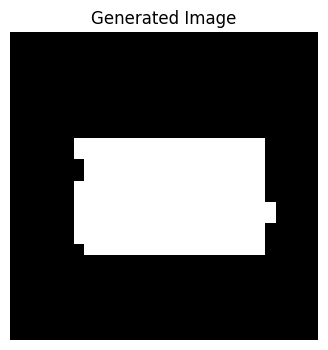

Predicted Alpha: 0.69


In [ ]:
# Define the function to generate an image
def generate_image(latent_vector, alpha_value):
    latent_vector = np.array(latent_vector).reshape((1, latent_dim))
    alpha_value = np.array(alpha_value).reshape((1, *property_shape))
    generated_image = decoder.predict([latent_vector, alpha_value])
    thresholded_image = np.round(generated_image)
    return thresholded_image[0]

# Global variable to store the generated image
generated_image = None

# Create widgets
alpha_input = widgets.FloatText(
    value=1.0,
    description='Alpha:',
    layout=widgets.Layout(width='50%')
)
generate_button = widgets.Button(description='Generate Image')
calculate_alpha_button = widgets.Button(description='Calculate Alpha')

# Function to handle the generate image button click
def on_generate_button_clicked(b):
    global generated_image
    clear_output(wait=True)
    display(ui)

    latent_vector = np.random.randn(latent_dim)
    alpha_value = alpha_input.value

    generated_image = generate_image(latent_vector, alpha_value)

    plt.figure(figsize=(4, 4))
    plt.imshow(generated_image.squeeze(), cmap='gray')
    plt.title('Generated Image')
    plt.axis('off')
    plt.show()

# Function to handle the calculate alpha button click
def on_calculate_alpha_button_clicked(b):
    global generated_image
    if generated_image is None:
        print("Please generate an image first")
        return

    predicted_alpha = compute_alpha(generated_image.squeeze())
    print(f'Predicted Alpha: {predicted_alpha:.2f}')

generate_button.on_click(on_generate_button_clicked)
calculate_alpha_button.on_click(on_calculate_alpha_button_clicked)

# Layout the widgets
ui = widgets.VBox([alpha_input, generate_button, calculate_alpha_button])
display(ui)


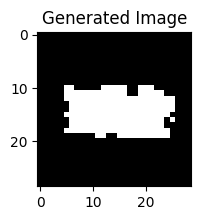

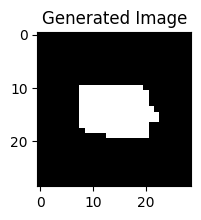

Alpha for Image 1: 0.56
Alpha for Image 2: 0.84


In [ ]:
display(ui)
